In [1]:
import pandas as pd

In [2]:
daily = pd.read_csv('daily.csv').drop('Unnamed: 0',axis=1)

In [3]:
len(daily)

2088

In [4]:
import numpy as np

In [5]:
np.random.seed(31415)

## Todays data, tomorrow morning's fatigue rating

In [6]:
daily.columns

Index(['index', 'PlayerID', 'AvgImpulseSpike', 'Date', 'DaysSinceLast',
       'DaysTillNext', 'DistanceLastGame', 'AvgSpeedLastGame', 'Fatigue',
       'Soreness', 'Desire', 'Irritability', 'BedTime', 'WakeTime',
       'SleepHours', 'SleepQuality', 'MonitoringScore', 'Pain', 'Illness',
       'Menstruation', 'Nutrition', 'NutritionAdjustment', 'USGMeasurement',
       'USG', 'TrainingReadiness', 'Fatigue_standard', 'Soreness_standard',
       'Desire_standard', 'Irritability_standard', 'SleepHours_standard',
       'SleepQuality_standard', 'MonitoringScore_standard', 'USG_standard',
       'LastWins', 'LastLosses', 'LastWLDiff', 'LastWon', 'avgRPE',
       'avgSessionDuration', 'TotalTrainingSessions', 'ConditioningSession',
       'GameSession', 'Mobility/RecoverySession', 'SkillsSession',
       'SpeedSession', 'StrengthSession', 'CombatSession', 'TrainingDay',
       'RestDay', 'interactAvgSessionDurationTraining',
       'interactAvgRPETraining', 'DistanceLastGame*DaysSinceLast',

In [7]:
X = daily[['AvgImpulseSpike',
#            'DistanceLastGame*DaysSinceLast',
#            'AvgImpulseSpike*DaysSinceLast',
           'DaysSinceLast', 'DaysTillNext',
       'DistanceLastGame', 'AvgSpeedLastGame', 
       'Pain', 'Illness', 'Menstruation', 'Nutrition',
       'NutritionAdjustment', 'TrainingReadiness',
       'Soreness_standard', 'Desire_standard',
       'Irritability_standard', 'SleepHours_standard', 'SleepQuality_standard',
       'LastWLDiff', 'LastWon', 'avgRPE',
       'avgSessionDuration', 'TotalTrainingSessions', 'ConditioningSession',
       'GameSession', 'Mobility/RecoverySession', 'SkillsSession',
       'SpeedSession', 'StrengthSession', 'CombatSession', 'TrainingDay',
       'RestDay']]

In [8]:
X = pd.get_dummies(X, drop_first = True)

In [9]:
X['DaysSinceLast'] = X['DaysSinceLast'] - X['DaysSinceLast'].mean()

In [10]:
X['DaysTillNext'] = X['DaysTillNext'] - X['DaysTillNext'].mean()

--------

In [11]:
def to_cat(fatigue_standard):
    if fatigue_standard <= -0.6:
        return 'Low'
    elif fatigue_standard <= 0.6:
        return 'Mid'
    else:
        return 'High'

In [12]:
y = daily['Fatigue_standard']
y_cat = pd.Series([to_cat(fatigue) for fatigue in y])
sum(y_cat=='Low'), sum(y_cat=='Mid'), sum(y_cat=='High')

(574, 841, 673)

In [13]:
np.random.seed(31415)

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=0)

# Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
basicForest = RandomForestClassifier(class_weight = 'balanced')
basicForest.fit(x_train, y_train)
predicted = basicForest.predict(x_test)

from sklearn.model_selection import cross_val_score
trainscore = np.mean(cross_val_score(basicForest, x_train, y_train, cv=5))
testscore = np.mean(cross_val_score(basicForest, x_test, y_test, cv=5))
print("Train Score:", trainscore)
print("Test Score:", testscore)

/Users/markelle/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Train Score: 0.6187297433774209
Test Score: 0.5548092633582092


### Step 1. Find optimal hyperparameters

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
param_grid = {'n_estimators':[5,10,50,100,150],
              'criterion':['gini','entropy']}

grid = GridSearchCV(RandomForestClassifier(class_weight = 'balanced'), param_grid, cv=5)
grid.fit(x_test, y_test);

/Users/markelle/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [19]:
model = grid.best_estimator_
model

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

### Step 2. Fit and predict from this model

In [907]:
model.fit(x_train, y_train);

In [908]:
predictions = model.predict(x_test)
trainscore = np.mean(cross_val_score(model, x_train, y_train, cv=5))
testscore = np.mean(cross_val_score(model, x_test, y_test, cv=5))
print("Train Score:", round(trainscore,3))
print("Test Score:", round(testscore,3))

Train Score: 0.657
Test Score: 0.606


### Step 3. Feature Reduction

Optimal number of features : 8


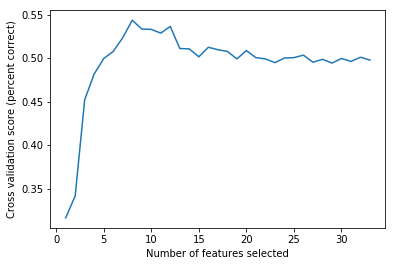

In [909]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5))
rfecv.fit(X, y_cat)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (percent correct)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [911]:
from sklearn.feature_selection import RFE

model2 = RandomForestClassifier()
rfe = RFE(model2, 9)
fit = rfe.fit(x_train, y_train)
print("Num Features:",fit.n_features_)
print("Features to Keep:")
features = pd.concat([pd.Series(fit.support_), pd.Series(x_train.columns)], axis = 1)\
    .reset_index().drop('index', axis = 1)\
    .rename(columns = {0:'Keep?',1:'Feature'})
features[features['Keep?']==True]

Num Features: 9
Features to Keep:


,Keep?,Feature
0,True,AvgImpulseSpike
1,True,DaysSinceLast
2,True,DaysTillNext
4,True,AvgSpeedLastGame
6,True,Soreness_standard
7,True,Desire_standard
9,True,SleepHours_standard
10,True,SleepQuality_standard
13,True,avgRPE


In [912]:
list(features[features['Keep?']==True]['Feature'])

['AvgImpulseSpike',
 'DaysSinceLast',
 'DaysTillNext',
 'AvgSpeedLastGame',
 'Soreness_standard',
 'Desire_standard',
 'SleepHours_standard',
 'SleepQuality_standard',
 'avgRPE']

In [913]:
X_sub = X[list(features[features['Keep?']==True]['Feature'])]

In [914]:
np.random.seed(31415)

In [915]:
x_train, x_test, y_train, y_test = train_test_split(X_sub, y_cat, test_size=0.3, random_state=0)

In [916]:
model.fit(x_train, y_train);

In [917]:
predictions = model.predict(x_test)
trainscore = np.mean(cross_val_score(model, x_train, y_train, cv=5))
testscore = np.mean(cross_val_score(model, x_test, y_test, cv=5))
print("Train Score:", round(trainscore,3))
print("Test Score:", round(testscore,3))

Train Score: 0.654
Test Score: 0.603


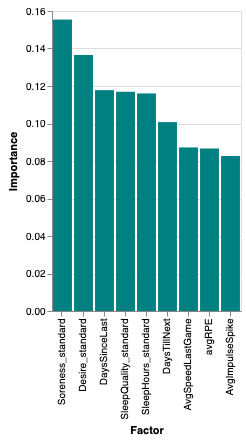

In [918]:
importances = pd.DataFrame({'importance': model.feature_importances_, 
                            'feature':X_sub.columns})

importances['color'] = importances['importance']>0.03
import altair as alt
alt.Chart(importances).mark_bar(color='teal').encode(
    alt.X('feature', axis = alt.Axis(title='Factor'), 
          sort = alt.EncodingSortField(field='importance',op='sum',order='descending')
    ),
    alt.Y('importance', axis = alt.Axis(title = "Importance")),
    #alt.Color('color', title='Keep?', scale = alt.Scale(domain=[True,False], range=['navy','teal']))
)

### Step 4. (Remove?), fit, predict

In [803]:
model.fit(x_train, y_train);

In [804]:
predictions = model.predict(x_test)
trainscore = np.mean(cross_val_score(model, x_train, y_train, cv=5))
testscore = np.mean(cross_val_score(model, x_test, y_test, cv=5))
print("Train Score:", round(trainscore,3))
print("Test Score:", round(testscore,3))

Train Score: 0.664
Test Score: 0.608


In [805]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

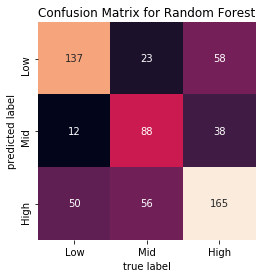

In [806]:
mat = confusion_matrix(y_test, predictions)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion Matrix for Random Forest')
plt.xticks([0.5,1.5,2.5],['Low','Mid','High'])
plt.yticks([0.5,1.5,2.5],['Low','Mid','High'])
plt.show()

# Neural Net

In [178]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
nn.fit(x_train, y_train);

In [179]:
predictions = nn.predict(x_test)
trainscore = nn.score(x_train, y_train)
testscore = nn.score(x_test, y_test)
print("Train Score:", trainscore)
print("Test Score:", testscore)

Train Score: 0.4208754208754209
Test Score: 0.36910994764397903


# Naive Bayes

In [180]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train);

In [181]:
pred = nb.predict(x_test)
trainscore = nb.score(x_train, y_train)
testscore = nb.score(x_test, y_test)
print("Train Score:", trainscore)
print("Test Score:", testscore)

Train Score: 0.5173961840628507
Test Score: 0.4712041884816754


# KNN

In [475]:
x_train, x_test, y_train, y_test = train_test_split(X_sub, y_cat, test_size=0.3, random_state=0)

In [476]:
from sklearn.neighbors import KNeighborsClassifier
kn = KNeighborsClassifier()
kn.fit(x_train, y_train);

In [477]:
pred = kn.predict(x_test)
trainscore = kn.score(x_train, y_train)
testscore = kn.score(x_test, y_test)
print("Train Score:", trainscore)
print("Test Score:", testscore)

Train Score: 0.6249144421629022
Test Score: 0.4609250398724083


In [480]:
model.feature_importances_

array([0.15266135, 0.1159905 , 0.10067037, 0.11147827, 0.08314582,
       0.10378761, 0.09943877, 0.07897929, 0.0802518 , 0.07359623])

In [481]:
len(X.columns)

35

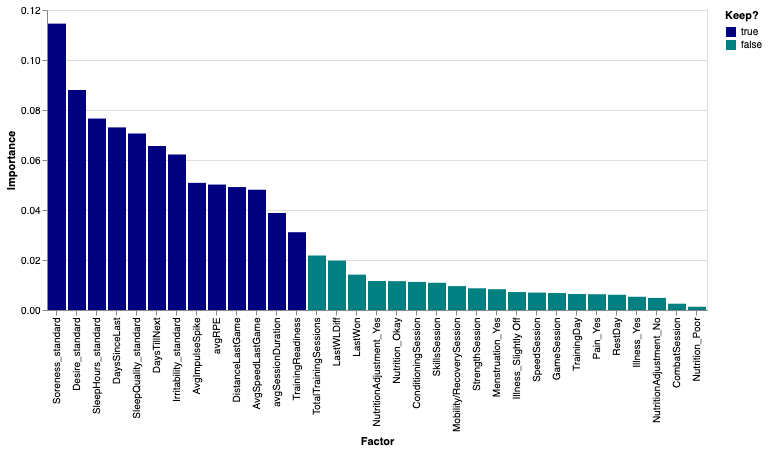

In [20]:
importances = pd.DataFrame({'importance': model.feature_importances_, 'feature':X.columns})

importances['color'] = importances['importance']>0.03
import altair as alt
alt.Chart(importances).mark_bar().encode(
    alt.X('feature', axis = alt.Axis(title='Factor'), 
          sort = alt.EncodingSortField(field='importance',op='sum',order='descending')
    ),
    alt.Y('importance', axis = alt.Axis(title = "Importance")),
    alt.Color('color', title='Keep?', scale = alt.Scale(domain=[True,False], range=['navy','teal']))
)

# Linear Regression

In [488]:
from sklearn.linear_model import LinearRegression

In [494]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [495]:
linReg = LinearRegression()
linReg.fit(x_train, y_train)
predicted = linReg.predict(x_test)

from sklearn.model_selection import cross_val_score
trainscore = np.mean(cross_val_score(linReg, x_train, y_train, cv=5))
testscore = np.mean(cross_val_score(linReg, x_test, y_test, cv=5))
print("Train Score:", trainscore)
print("Test Score:", testscore)

Train Score: 0.34404522105425867
Test Score: 0.3297506299101075


# Naive Bayes

In [571]:
x_train, x_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=0)

In [572]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB(priors=None)

In [573]:
pred = nb.predict(x_test)
trainscore = nb.score(x_train, y_train)
testscore = nb.score(x_test, y_test)
print("Train Score:", trainscore)
print("Test Score:", testscore)

trainscore = np.mean(cross_val_score(nb, x_train, y_train, cv=5))
testscore = np.mean(cross_val_score(nb, x_test, y_test, cv=5))
print("CV Train Score:", trainscore)
print("CV Test Score:", testscore)

Train Score: 0.5817932922655715
Test Score: 0.5550239234449761
CV Train Score: 0.5092267053158165
CV Test Score: 0.5118991174490285


# Gaussian Process

In [567]:
x_train, x_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.3, random_state=0)

In [568]:
from sklearn.gaussian_process import GaussianProcessClassifier
gpc = GaussianProcessClassifier()
gpc.fit(x_train, y_train)

GaussianProcessClassifier(copy_X_train=True, kernel=None,
             max_iter_predict=100, multi_class='one_vs_rest', n_jobs=1,
             n_restarts_optimizer=0, optimizer='fmin_l_bfgs_b',
             random_state=None, warm_start=False)

In [574]:
pred = gpc.predict(x_test)
trainscore = gpc.score(x_train, y_train)
testscore = gpc.score(x_test, y_test)
print("Train Score:", trainscore)
print("Test Score:", testscore)

trainscore = np.mean(cross_val_score(gpc, x_train, y_train, cv=5))
testscore = np.mean(cross_val_score(gpc, x_test, y_test, cv=5))
print("CV Train Score:", trainscore)
print("CV Test Score:", testscore)

Train Score: 1.0
Test Score: 0.4433811802232855
CV Train Score: 0.428474917013418
CV Test Score: 0.4289973833915922
